[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kevin7261/Geographic-Data-Science-with-Python/blob/main/Choropleth_Mapping.ipynb)

# ChoroplethMapping

https://geographicdata.science/book/notebooks/05_choropleth.html

[台北市里界圖](https://data.taipei/dataset/detail?id=6b17b31d-4e16-495e-95b1-9fd1f47c80d8)

In [94]:
# @title 初始值設定

PROJECT_NAME = "臺北市_村里_綜稅綜合所得總額"
GPKG_FILE_PATH = "https://drive.google.com/file/d/1cmW_VxEyyRZ9xILM_7Blq98r7B40SwqA/view?usp=sharing"

In [95]:
# @title 下載台北思源黑體

# 下載台北思源黑體，並隱藏輸出
!wget -q -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 匯入必要的庫
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 新增字體
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')

# 設定字體
mpl.rc('font', family='Taipei Sans TC Beta')


In [96]:
# @title 安裝套件

!pip install -q geopandas gdown pysal

---

In [97]:
# @title read_shape_file

import geopandas as gpd
import gdown
import os

SPREADSHEET_ID = GPKG_FILE_PATH.split("/d/")[1].split("/")[0]

def read_shape_file():

    # ✅ 設定下載與儲存路徑
    gpkg_path = f"{PROJECT_NAME}.gpkg"

    # ✅ 下載 .gpkg 檔案（從 Google Drive）
    gdown.download(
        url=f"https://drive.google.com/uc?id={SPREADSHEET_ID}",
        output=gpkg_path,
        quiet=True
    )

    # ✅ 使用 GeoPandas 自動讀取第一層
    gdf = gpd.read_file(gpkg_path)

    # ✅ 顯示 GeoDataFrame 頭部
    print("📋 GeoDataFrame 頭部：")
    print(gdf.head())

    return gdf

# ✅ 執行
gdf = read_shape_file()

📋 GeoDataFrame 頭部：
           AREA           NEW       FULL  PERF_ID  COUN_ID   CPID    CPTID  \
0  1.632654e+07  6.301200e+09  臺北市北投區湖田里  63012.0  6301200  63012  6301200   
1  1.171811e+07  6.301100e+09  臺北市士林區菁山里  63011.0  6301100  63011  6301100   
2  4.348102e+06  6.301200e+09  臺北市北投區大屯里  63012.0  6301200  63012  6301200   
3  6.429150e+06  6.301100e+09  臺北市士林區平等里  63011.0  6301100  63011  6301100   
4  5.026572e+06  6.301200e+09  臺北市北投區泉源里  63012.0  6301200  63012  6301200   

       CPTVID     NPID      NPTID  ...   村里 納稅單位(戶)  綜合所得總額   平均數  中位數 第一分位數  \
0  6301200042  63012.0  6301200.0  ...  湖田里     229  181734   794  389   164   
1  6301100047  63011.0  6301100.0  ...  菁山里     425  492449  1159  440   221   
2  6301200041  63012.0  6301200.0  ...  大屯里     334  308380   923  481   239   
3  6301100048  63011.0  6301100.0  ...  平等里     396  301382   761  462   244   
4  6301200039  63012.0  6301200.0  ...  泉源里     664  504975   761  411   191   

  第三分位數      標準差    變異係數       

# Principles

In [98]:
# @title 匯入函式庫

import seaborn
import pandas
import geopandas
import pysal
import numpy
import matplotlib.pyplot as plt

## 資料集

1. 臺北市_村里_綜稅綜合所得總額 (gpkg)

# Quantitative data classification

In [99]:
mx = geopandas.read_file(f"{PROJECT_NAME}.gpkg")
mx[["FULL", "中位數"]].head()

,FULL,中位數
0,臺北市北投區湖田里,389
1,臺北市士林區菁山里,440
2,臺北市北投區大屯里,481
3,臺北市士林區平等里,462
4,臺北市北投區泉源里,411


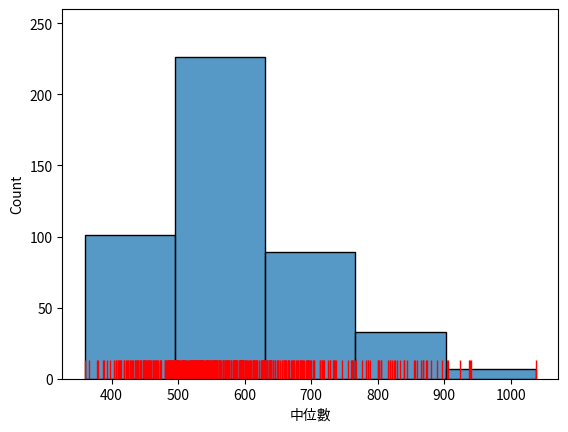

In [100]:
# Plot histogram
ax = seaborn.histplot(mx["中位數"], bins=5)
# Add rug on horizontal axis
seaborn.rugplot(mx["中位數"], height=0.05, color="red", ax=ax);

In [101]:
mx["中位數"].describe()

,中位數
count,456.000000
mean,585.210526
std,117.420329
min,360.000000
25%,502.750000
50%,567.500000
75%,643.000000
max,1038.000000


In [102]:
counts, bins, patches = ax.hist(mx["中位數"], bins=5)

In [103]:
counts # 數量

array([101., 226.,  89.,  33.,   7.])

In [104]:
bins # 斷點

array([ 360. ,  495.6,  631.2,  766.8,  902.4, 1038. ])

In [105]:
import mapclassify

## Equal intervals

In [106]:
ei5 = mapclassify.EqualInterval(mx["中位數"], k=5)
ei5

EqualInterval

     Interval        Count
--------------------------
[ 360.00,  495.60] |   101
( 495.60,  631.20] |   226
( 631.20,  766.80] |    89
( 766.80,  902.40] |    33
( 902.40, 1038.00] |     7

## Quantiles 分位數

In [107]:
q5 = mapclassify.Quantiles(mx.中位數, k=5)
q5

Quantiles

     Interval        Count
--------------------------
[ 360.00,  491.00] |    94
( 491.00,  542.00] |    90
( 542.00,  594.00] |    93
( 594.00,  667.00] |    89
( 667.00, 1038.00] |    90

In [108]:
q5.bins[1:] - q5.bins[:-1]

array([ 51.,  52.,  73., 371.])

In [109]:
# 隨機產生資料

# Set seed for reproducibility
numpy.random.seed(12345)
# Generate a variable of 20 values randomly
# selected from 0 to 10
x = numpy.random.randint(0, 10, 20)
# Manually ensure the first ten values are 0 (the
# minimum value)
x[0:10] = x.min()
x

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 7, 6, 0, 2, 9, 1, 2, 6, 7])

In [110]:
ties = mapclassify.Quantiles(x, k=5)
ties

/usr/local/lib/python3.11/dist-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


Quantiles

  Interval     Count
--------------------
[0.00, 0.00] |    11
(0.00, 1.40] |     1
(1.40, 6.20] |     4
(6.20, 9.00] |     4

In [111]:
ux = numpy.unique(x)
ux

array([0, 1, 2, 6, 7, 9])

## Mean-standard deviation 平均標準差

In [112]:
msd = mapclassify.StdMean(mx["中位數"])
msd

StdMean

     Interval        Count
--------------------------
(   -inf,  350.37] |     0
( 350.37,  467.79] |    66
( 467.79,  702.63] |   326
( 702.63,  820.05] |    38
( 820.05, 1038.00] |    26

## Maximum breaks

In [113]:
mb5 = mapclassify.MaximumBreaks(mx["中位數"], k=5)
mb5

MaximumBreaks

     Interval        Count
--------------------------
[ 360.00,  794.00] |   422
( 794.00,  915.00] |    29
( 915.00,  930.50] |     1
( 930.50,  989.00] |     3
( 989.00, 1038.00] |     1

## Boxplot

In [114]:
bp = mapclassify.BoxPlot(mx["中位數"])
bp

BoxPlot

     Interval        Count
--------------------------
(   -inf,  292.38] |     0
( 292.38,  502.75] |   114
( 502.75,  567.50] |   114
( 567.50,  643.00] |   116
( 643.00,  853.38] |    94
( 853.38, 1038.00] |    18

In [115]:
bp1 = mapclassify.BoxPlot(mx["中位數"], hinge=1)
bp1

BoxPlot

     Interval        Count
--------------------------
[ 360.00,  362.50] |     1
( 362.50,  502.75] |   113
( 502.75,  567.50] |   114
( 567.50,  643.00] |   116
( 643.00,  783.25] |    75
( 783.25, 1038.00] |    37

## Head-tail breaks

In [116]:
ht = mapclassify.HeadTailBreaks(mx["中位數"])
ht

HeadTailBreaks

     Interval        Count
--------------------------
[ 360.00,  585.21] |   258
( 585.21,  689.53] |   125
( 689.53,  792.16] |    39
( 792.16,  861.76] |    19
( 861.76,  906.93] |    10
( 906.93,  955.60] |     4
( 955.60, 1038.00] |     1

## Jenks-Caspall breaks

In [117]:
numpy.random.seed(12345)
jc5 = mapclassify.JenksCaspall(mx["中位數"], k=5)
jc5

JenksCaspall

     Interval        Count
--------------------------
[ 360.00,  475.00] |    72
( 475.00,  551.00] |   128
( 551.00,  624.00] |   115
( 624.00,  737.00] |    94
( 737.00, 1038.00] |    47

## Fisher-Jenks breaks

In [118]:
numpy.random.seed(12345)
fj5 = mapclassify.FisherJenks(mx["中位數"], k=5)
fj5

FisherJenks

     Interval        Count
--------------------------
[ 360.00,  475.00] |    72
( 475.00,  561.00] |   148
( 561.00,  646.00] |   126
( 646.00,  768.00] |    71
( 768.00, 1038.00] |    39

## Max-p

In [119]:
mp5 = mapclassify.MaxP(mx["中位數"], k=5)
mp5

MaxP

     Interval        Count
--------------------------
[ 360.00,  491.00] |    94
( 491.00,  593.00] |   179
( 593.00,  594.00] |     4
( 594.00,  667.00] |    89
( 667.00, 1038.00] |    90

## Comparing classification schemes

<ipython-input-120-bd4591d25ded>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = seaborn.barplot(


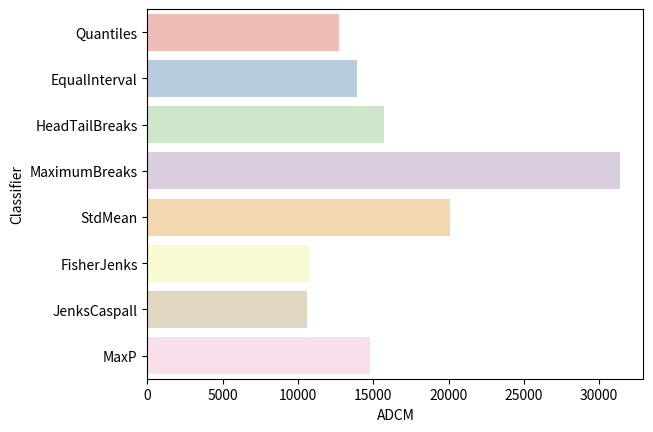

In [120]:
# 計算ADCM (absolute deviation around class medians)，越低越好

# Bunch classifier objects
class5 = q5, ei5, ht, mb5, msd, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = numpy.array([c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pandas.DataFrame(fits)
# Add classifier names
adcms["classifier"] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ["ADCM", "Classifier"]
ax = seaborn.barplot(
    y="Classifier", x="ADCM", data=adcms, palette="Pastel1"
)

In [121]:
# Append class values as a separate column
mx["Quantiles"] = q5.yb
mx["Equal Interval"] = ei5.yb
mx["Head-Tail Breaks"] = ht.yb
mx["Maximum Breaks"] = mb5.yb
mx["Mean-Standard Deviation"] = msd.yb
mx["Fisher-Jenks"] = fj5.yb
mx["Jenks Caspall"] = jc5.yb
mx["MaxP"] = mp5.yb

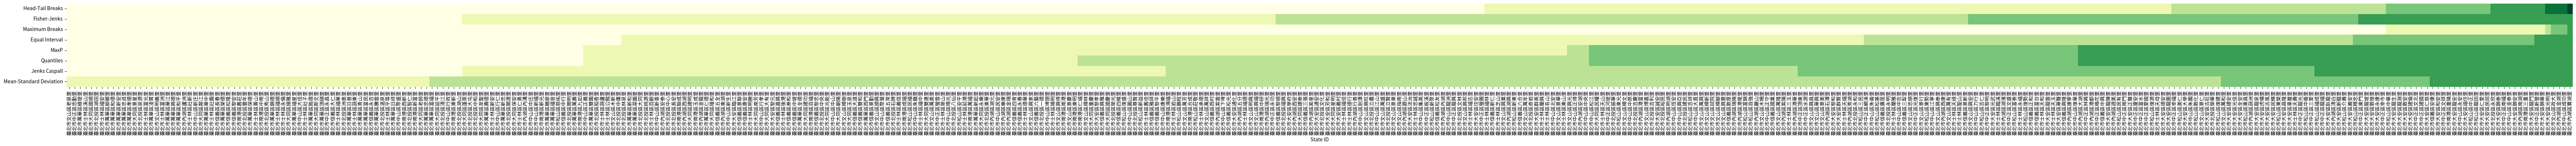

In [122]:
#f, ax = plt.subplots(1, figsize=(9, 3))
f, ax = plt.subplots(1, figsize=(90, 3))
seaborn.heatmap(
    mx.set_index("FULL")
    .sort_values("中位數")[
        [
            "Head-Tail Breaks",
            "Fisher-Jenks",
            "Maximum Breaks",
            "Equal Interval",
            "MaxP",
            "Quantiles",
            "Jenks Caspall",
            "Mean-Standard Deviation",
        ]
    ]
    .T,
    cmap="YlGn",
    cbar=False,
    ax=ax,
)
ax.set_xlabel("State ID");

In [123]:
# ✅ 建立修正後的 class5，確保每個 c.counts 長度為 5（多的截斷、少的補 NaN）
class5_fixed = []

for c in class5:
    counts = list(c.counts)
    # 若群數少於 5 → 補 NaN
    while len(counts) < 5:
        counts.append(float("nan"))
    # 若群數多於 5 → 截斷
    counts = counts[:5]

    # 模擬一個物件，具有 c.name 和截斷後 counts 屬性
    class Fixed:
        pass

    fixed = Fixed()
    fixed.name = c.name
    fixed.counts = counts
    class5_fixed.append(fixed)

# ✅ 完全照你要求的寫法建立表格
pandas.DataFrame(
    {c.name: c.counts for c in class5_fixed},
    index=["Class-{}".format(i) for i in range(5)],
)

,Quantiles,EqualInterval,HeadTailBreaks,MaximumBreaks,StdMean,FisherJenks,JenksCaspall,MaxP
Class-0,94,101,258,422,0,72,72,94
Class-1,90,226,125,29,66,148,128,179
Class-2,93,89,39,1,326,126,115,4
Class-3,89,33,19,3,38,71,94,89
Class-4,90,7,10,1,26,39,47,90


In [124]:
# pandas.DataFrame(
#     {c.name: c.counts for c in class5},
#     index=["Class-{}".format(i) for i in range(5)],
# )

# Color

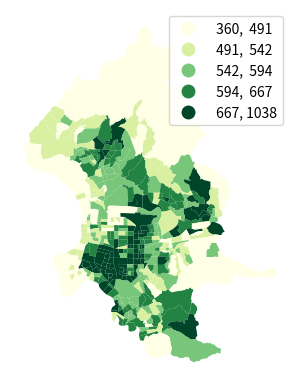

In [125]:
ax = mx.plot(
    column="中位數",  # Data to plot
    scheme="Quantiles",  # Classification scheme
    cmap="YlGn",  # Color palette
    legend=True,  # Add legend
    legend_kwds={"fmt": "{:.0f}"},  # Remove decimals in legend
)
ax.set_axis_off();

## Sequential palettes

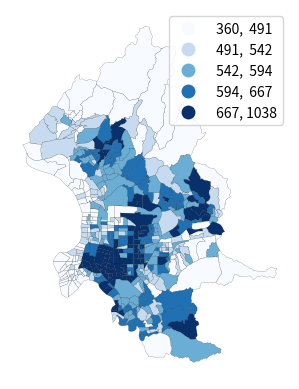

In [126]:
ax = mx.plot(
    column="中位數",  # Data to plot
    scheme="Quantiles",  # Classification scheme
    cmap="Blues",  # Color palette
    edgecolor="k",  # Borderline color
    linewidth=0.1,  # Borderline width
    legend=True,  # Add legend
    legend_kwds={
        "fmt": "{:.0f}"
    },  # Remove decimals in legend (for legibility)
)
ax.set_axis_off();

## Diverging palettes

In [127]:
# Create income-based rank table (Rank 1 is highest)
rnk = mx[["FULL", "中位數", "平均數"]].rank(ascending=False)
# Compute change from 中位數 to 平均數
rnk["change"] = rnk["中位數"] - rnk["平均數"]
# Add column with bin class
#rnk["class"] = pandas.cut(rnk["change"], [-numpy.inf, -5, 0, 5, 20])
rnk["class"] = pandas.cut(rnk["change"], [-300, -50, 0, 50, 300])

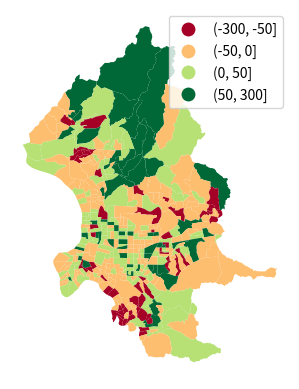

In [128]:
ax = (
    mx[["geometry"]]
    .join(rnk)
    .plot("class", legend=True, cmap="RdYlGn")
)
ax.set_axis_off();

## Qualitative palettes

In [129]:
mx["JenksCaspall"] = jc5.yb # 儲存中位數分類

In [130]:
mx["JenksCaspall"].head()

,JenksCaspall
0,0
1,0
2,1
3,0
4,0


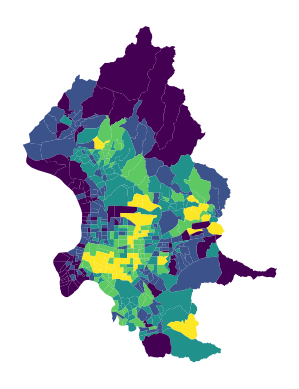

In [131]:
ax = mx.plot("JenksCaspall")
ax.set_axis_off();

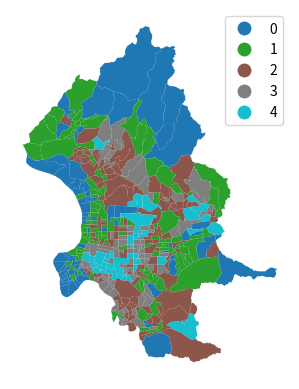

In [132]:
ax = mx.plot("JenksCaspall", categorical=True, legend=True)
ax.set_axis_off();

# Advanced topics

## User-defined choropleths

In [133]:
classi = mapclassify.UserDefined(
    #mx["平均數"], [10000, 12500, 15000]
    mx["平均數"], [800, 1000, 1200]
)
classi

UserDefined

     Interval        Count
--------------------------
[ 523.00,  800.00] |    70
( 800.00, 1000.00] |   149
(1000.00, 1200.00] |   108
(1200.00, 2954.00] |   129

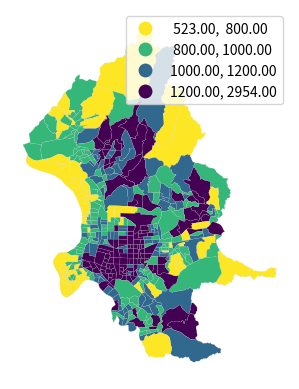

In [134]:
classi.plot(
    mx,  # Use geometries in the geo-table
    legend=True,  # Add a legend
    legend_kwds={
        "loc": "upper right"
    },  # Place legend on top right corner
    axis_on=False,  # Remove axis
    cmap="viridis_r",  # Use reverse Viridis
);

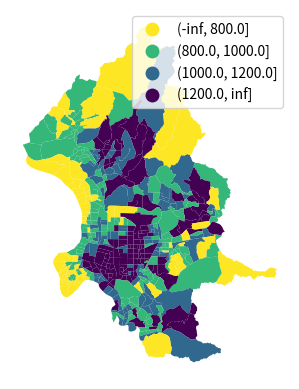

In [135]:
# Classify values specifying bins
lbls = pandas.cut(
    #mx["平均數"], [-numpy.inf, 10000, 12500, 15000, numpy.inf]
    mx["平均數"], [-numpy.inf, 800, 1000, 1200, numpy.inf]
)
# Dynamically assign to geo-table and plot with a legend
ax = mx.plot(lbls, cmap="viridis_r", legend=True)
# Remove axis
ax.set_axis_off();

## Pooled classifications

In [136]:
# List the years we want of pc GDP
years = ["中位數", "平均數", "第一分位數", "第三分位數"]
# Create pooled classification
pooled = mapclassify.Pooled(mx[years], classifier="Quantiles", k=5)

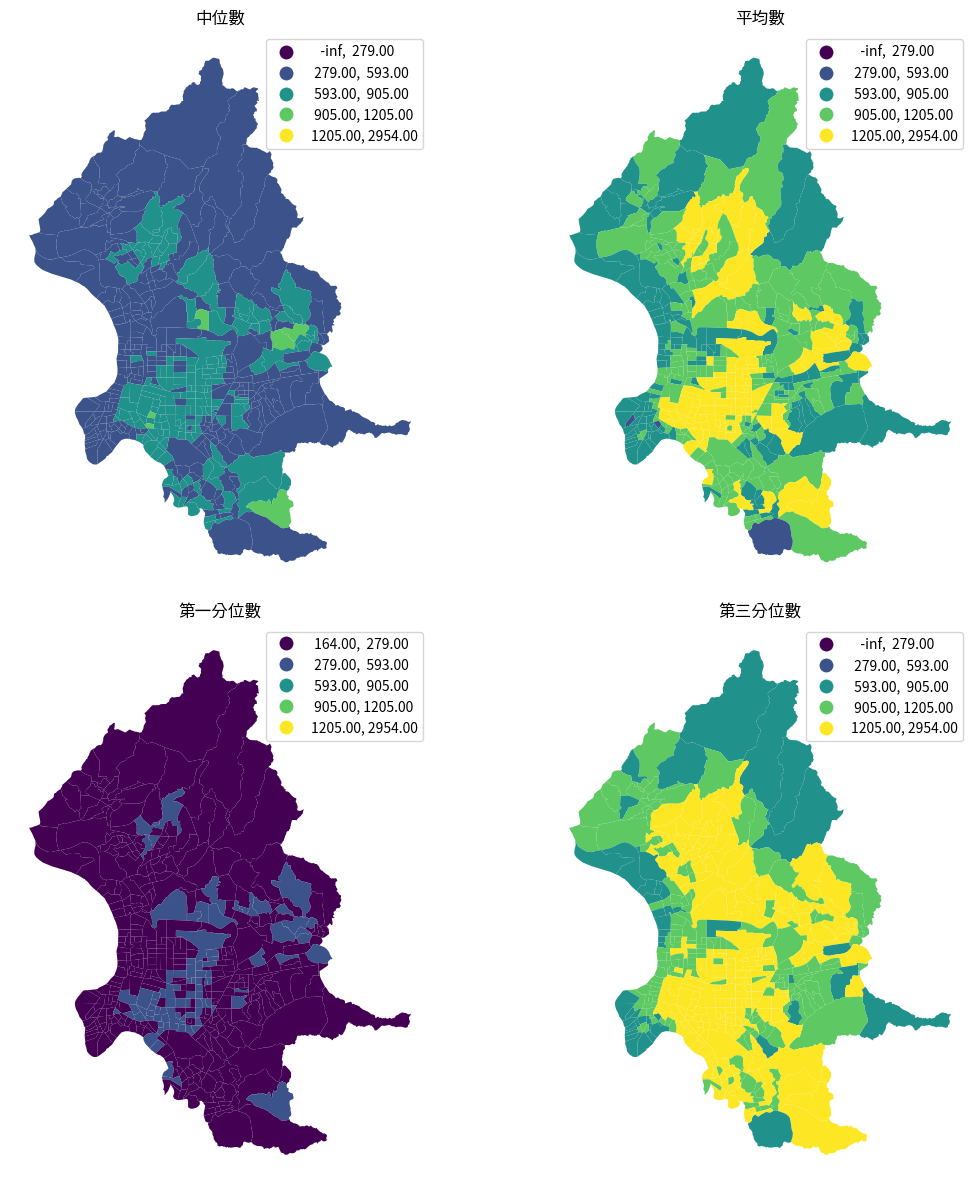

In [137]:
# Set up figure with four axis
f, axs = plt.subplots(2, 2, figsize=(12, 12))
# Flatten the array of axis so you can loop over
# in one dimension
axs = axs.flatten()
# Loop over each year
for i, y in enumerate(years):
    mx.plot(
        y,  # Year to plot
        scheme="UserDefined",  # Use our own bins
        classification_kwds={
            "bins": pooled.global_classifier.bins
        },  # Use global bins
        legend=True,  # Add a legend
        ax=axs[i],  # Plot on the corresponding axis
    )
    # Remove axis
    axs[i].set_axis_off()
    # Name the subplot with the name of the column
    axs[i].set_title(y)
# Tight layout to better use space
plt.tight_layout()
# Display figure
plt.show()

# Conclusion